In [1]:
#Resources: https://www.youtube.com/watch?v=9aYuQmMJvjA&list=PLQVvvaa0QuDdeMyHEYc0gxFpYwHY2Qfdh&index=5
#Dataset: https://www.microsoft.com/en-us/download/details.aspx?id=54765

import torch 
import torch.nn as nn
from IPython.display import Image
import pandas as pd
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from tqdm import tqdm
import torch.optim as optim

In [2]:
REBUILD_DATA = True #In our pre-processing dataset we don't want to build data every single time you run the code

In [3]:
class DogsVSCats():
    
    IMG_SIZE = 50 #50x50 images - we need them to be uniform on the input
    CATS = "PetImages/Cat"
    DOGS = "PetImages/Dog"
    LABELS = {CATS: 0, DOGS: 1}

    training_data = []
    cat_count = 0
    dog_count = 0

    def make_training_data(self):
        for label in self.LABELS: #iterate over the directories
            for file in tqdm(os.listdir(label)): #iterate over all of the images within the directory
                try:
                    path = os.path.join(label, file)
                    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) #convert image to grayscale
                    img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                    self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]]) #convert things to one hot vector

                    if label == self.CATS:
                        self.cat_count += 1
                    elif label == self.DOGS:
                        self.dog_count += 1
                except Exception as exception:
                    pass

        np.random.shuffle(self.training_data)
        np.save("training_data.npy", self.training_data)
        print("Cats: ", self.cat_count)
        print("Dogs: ", self.dog_count)

In [4]:
if REBUILD_DATA:
    dogsvscats = DogsVSCats()
    dogsvscats.make_training_data()

100%|███████████████████████████████████████████████████████████████████████████| 12501/12501 [00:23<00:00, 535.57it/s]


Cats:  12476
Dogs:  12470


In [5]:
#Our data is already balanced since the number of dog images is almost equal to the number of cat images
print(dogsvscats.cat_count)
print(dogsvscats.dog_count)

12476
12470


In [6]:
training_data = np.load("training_data.npy", allow_pickle=True)

In [7]:
print(len(training_data))

24946


In [8]:
#It's a cat since our one hot array outputs hot for cat
print(training_data[0])

[array([[ 87,  60,  65, ...,  52,  49,  49],
       [ 68,  64,  64, ...,  54,  50,  57],
       [111,  74,  71, ...,  54,  56,  50],
       ...,
       [ 93,  85,  86, ...,  58,  67, 115],
       [ 87, 109,  96, ..., 132, 122,  88],
       [120,  91, 102, ...,  50,  82,  71]], dtype=uint8)
 array([0., 1.])]


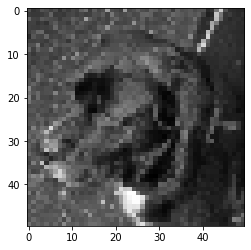

In [9]:
plt.imshow(training_data[0][0], cmap="gray")
plt.show()

In [10]:
class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        #2d convolutional layers are usually used on images, 3d convolutional layers are used on scans/models and 
        #1d convolutional layers are usually used on sequential or temporal type datasets with attention (and it seems
        #to be outperforming RNNs which were kind of the industry standard for doing any sort of sequential type of data).
        self.conv1 = nn.Conv2d(1, 32, 5) #input is 1, it outputs 32 convolutional features and we have a 5x5 kernel (window)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        
        x = torch.randn(50,50).view(-1,1,50,50)
        self._to_linear = None
        self.convs(x)
        
        #self.fc1 = nn.Linear(???, 512) we need to find the input number and this what _to_linear is going to do 
        self.fc1 = nn.Linear(self._to_linear, 512)
        self.fc2 = nn.Linear(512, 2)
        
    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
        x = F.max_pool2d(F.relu(self.conv3(x)), (2,2))
        
        #print(x[0].shape)
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        
        return x
    
    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear) #reshape to be flattened because after it comes out of convs() it's not flat yet
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.softmax(x, dim=1) 

In [11]:
net = Net()

In [12]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0 #scaling the images
y = torch.Tensor([i[1] for i in training_data])

VAL_PCT = 0.1
val_size = int(len(X)*VAL_PCT)
print(val_size)

2494


In [13]:
train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

22452
2494


In [14]:
BATCH_SIZE = 100
EPOCHS = 3

for epoch in range(EPOCHS):
    for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
        #print(i, i+BATCH_SIZE)
        batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
        batch_y = train_y[i:i+BATCH_SIZE]
        
        net.zero_grad()
        outputs = net(batch_X)
        loss = loss_function(outputs, batch_y)
        loss.backward()
        optimizer.step()
print(loss)

100%|████████████████████████████████████████████████████████████████████████████████| 225/225 [03:08<00:00,  1.19it/s]

tensor(0.1460, grad_fn=<MseLossBackward>)


In [15]:
correct = 0
total = 0
with torch.no_grad():
    for i in tqdm(range(len(test_X))):
        real_class = torch.argmax(test_y[i])
        net_out = net(test_X[i].view(-1,1,50,50))[0]
        
        predicted_class = torch.argmax(net_out)
        if predicted_class == real_class:
            correct += 1
        total += 1
print('Accuracy: ', round(correct/total, 3))

100%|█████████████████████████████████████████████████████████████████████████████| 2494/2494 [00:10<00:00, 237.84it/s]

Accuracy:  0.727


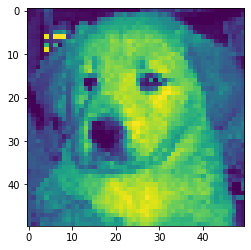

In [24]:
plt.imshow(test_X[2].view(50,50))
plt.show()

In [25]:
#LABELS = {CATS: 0, DOGS: 1}
print(test_y[2])

tensor([0., 1.])


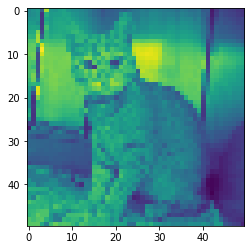

In [22]:
plt.imshow(test_X[0].view(50,50))
plt.show()

In [23]:
print(test_y[0])

tensor([1., 0.])


In [19]:
#Upload your own image so the model can predict whether it's a cat or a dog (one image at a time)
def predict(file_path):
    file = Image(filename=file_path)
    
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE) #convert image to grayscale
    img = cv2.resize(img, (50, 50))

    test = []
    test.append(np.array(img)) 
    test = torch.Tensor(img)

    with torch.no_grad():
        net_out = net(test.view(-1,1,50,50))
        predicted_class = torch.argmax(net_out)
    
    if predicted_class == 1:
        print("It's a dog!")
    else:
        print("It's a cat!")

In [20]:
predict('coragem.jpg')

It's a dog!


In [21]:
predict('lolla.jpg')

It's a dog!
